In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
from tensorflow.contrib import learn
from sklearn.metrics import mean_squared_error
from lstm import lstm_model, load_csvdata
from datetime import datetime
import Predictors as predictors
import stock_tools as st
import matplotlib.pyplot as plt
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Testing Deep learning

This is a test of a LSTM memory deep learning model to predict the SPY. It is written using tensorflow and is the process of being updated to tensrflow 1.0 The memory modules and the number of nodes have not be tuned, so predictions can be made better. At the moment only a small subset of the data is used due to the computational constraints.

In the future more predictors should be introduced as this will aid precission.

In [2]:
# Create a template with the available variables
interest = 'SPY'
start_date = datetime.strptime('2000-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2010-12-31', '%Y-%m-%d')

# Get the data and correct for fluctuations
data = st.get_data(start_date, end_date, from_file=True)
corr_data = st.ohlc_adj(data)
# Create a predictors class which we will base our decisions from
pred = predictors.Predictors(corr_data)

# The data is far too noisy to make accurate predictions.
# We apply a 5 day exponential rolling filter. This should preserve
# shape and reduce noise.
pred.e_filter(5)

In [6]:
# Setup the default vairables
LOG_DIR = '.opt_logs/lstm_stock'
TIMESTEPS = 20
RNN_LAYERS = [{'num_units': 5}]
DENSE_LAYERS = [10, 10]
TRAINING_STEPS = 100000
BATCH_SIZE = 100
PRINT_STEPS = TRAINING_STEPS / 100
LEARNING_RATE= 0.01
    
# We want to predict the Closing price. Not too much data
close = pred.data.Close.ix[(len(pred.props)-252*2):]

# Split the data into test and train
X, y = load_csvdata(close, TIMESTEPS, seperate=False)

In [7]:
# Create an regression model based on LSTM architecture
regressor = learn.Estimator(model_fn=lstm_model(TIMESTEPS, RNN_LAYERS, DENSE_LAYERS,
                                                learning_rate=LEARNING_RATE, optimizer="Adagrad"),
                           model_dir=LOG_DIR)

# create a lstm instance and validation monitor
validation_monitor = learn.monitors.ValidationMonitor(X['val'], y['val'],
                                                     every_n_steps=PRINT_STEPS,
                                                     early_stopping_rounds=1000)
# Fit the data to the models
regressor.fit(X['train'], y['train'],
              monitors=[validation_monitor],
              batch_size=BATCH_SIZE,
              steps=TRAINING_STEPS)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_save_checkpoints_secs': 600, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x10369ad30>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_environment': 'local', '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_num_ps_replicas': 0, '_is_chief': True, '_task_id': 0, '_tf_random_seed': None, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_master': ''}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled 

/anaconda/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Instructions for updating:
Use `tf.contrib.losses.mean_squared_error` and explicit logits computation.
Instructions for updating:
Use tf.losses.mean_squared_error instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 339006 into .opt_logs/lstm_stock/model.ckpt.
INFO:tensorflow:step = 339006, loss = 0.806717
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept i

Estimator(params=None)

In [8]:
# Make the prediction
predicted = list(regressor.predict(X['test']))

# Calculate the error
score = mean_squared_error(predicted, y['test'])
print ("MSE: %f" % score)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


/anaconda/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Instructions for updating:
Use `tf.contrib.losses.mean_squared_error` and explicit logits computation.
Instructions for updating:
Use tf.losses.mean_squared_error instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
MSE: 0.157704


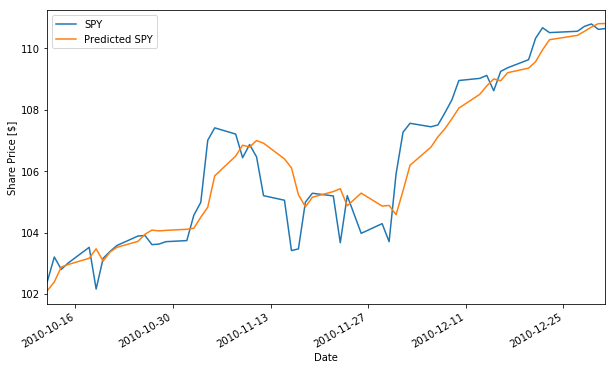

In [9]:
# plot the data
actual = close.ix[len(close)-len(predicted):]
predicted = pd.Series(predicted, index=actual.index)

comp = pd.DataFrame({"Actual": actual,"Pred":predicted})

plot_predicted = pred.props.price.ix[len(pred.props.price)-len(predicted):].plot(label='SPY', legend=True)
plot_test = comp.Pred.plot(label='Predicted SPY', legend=True)
plt.ylabel("Share Price [$]")
plt.show()

We can see that the preciction is the shape of the real data, however there is a delay. This is probably due to using the delayed exponential mean.

I have not made trading predictions using this model as the computation time is too long. But the trading model is presented in DL_BuySell.py